<a href="https://colab.research.google.com/github/leonmck-dsp-dev/nueraspeech/blob/main/nueraspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
import editdistance

from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


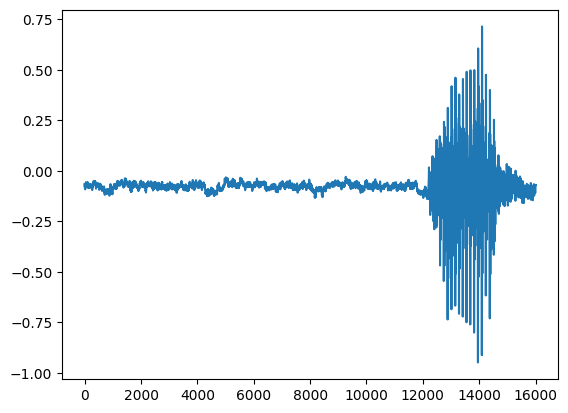

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

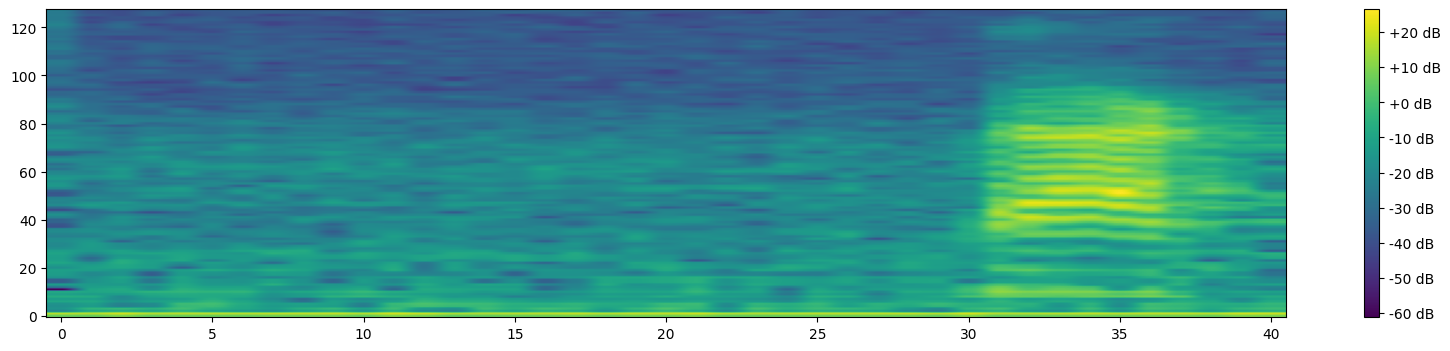

In [9]:
new_sample_rate = 8000

# 1. Resample
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resampler(waveform)

# 2. Convert to Mel-spectrogram
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128)
mel_spectrogram = mel_transform(resampled_waveform)

# 3. Convert to dB scale
db_transform = torchaudio.transforms.AmplitudeToDB()
db_mel_spectrogram = db_transform(mel_spectrogram)

mel_spectrogram_transform = torch.nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate),
    torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128),
    torchaudio.transforms.AmplitudeToDB()
)


# Display
plt.figure(figsize=(20, 4))
plt.imshow(db_mel_spectrogram[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format="%+2.0f dB")
plt.show()

print("Shape of the Mel spectrogram:", mel_spectrogram.shape)
# Listen to the resampled audio
ipd.Audio(resampled_waveform.numpy(), rate=new_sample_rate)


In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(tensor):
    # Convert tensor of indices into its string labels
    if tensor.dim() == 0:  # If tensor is a scalar
        return labels[tensor.item()]
    else:  # If tensor is not a scalar
        return [labels[index] for index in tensor.cpu().numpy()]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

Shape of the Mel spectrogram: torch.Size([1, 128, 41])
yes --> tensor(33) --> yes


In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [12]:
print(torch.__version__)

2.0.1+cu118


# Nueraspeech model architecture
## Acoustic Model (Convolutional Layers)

### Convolutional Neural Networks (CNNs)
A convolutional layer employs a set of learnable filters, which are used to spatially convolve with the input data to produce feature maps. Mathematically, for a 1D input $x$ and a filter $h$, convolution is represented as:

$$
y(t) = (x * h)(t) = \sum_{a=-\infty}^{\infty} x(a)h(t-a)
$$

### Batch Normalization

Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

$$
\hat{x} = \frac{x - \text{E}[x]}{\sqrt{\text{Var}[x]+\epsilon}}
$$

Where:
- $\hat{x}$ is the normalized data.
- $\text{E}[x]$ is the mean of the batch data.
- $\text{Var}[x]$ is the variance of the batch data.
- $\epsilon$ is a small constant to avoid division by zero.

---

## Recurrent Layers (GRU Layers)

### Gated Recurrent Units (GRUs)

GRUs are a type of recurrent neural network (RNN) architecture. The GRU uses gating mechanisms (reset gate and update gate) to control the flow of information.

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$
$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$
$$
\tilde{h}_t = \tanh(W x_t + r_t \odot (U h_{t-1} + b) + b')
$$
$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

Where:
- $r_t$ is the reset gate.
- $z_t$ is the update gate.
- $\tilde{h}_t$ is the candidate activation.
- $h_t$ is the output.
- $\sigma$ is the sigmoid function.
- $\odot$ is the element-wise multiplication.

---

## Transformer Attention

### Self Attention

The self-attention mechanism allows the model to weigh the significance of each part in a sequence based on its content. For a query $Q$, key $K$, and value $V$ set, the attention mechanism is defined as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where $d_k$ is the dimension of the keys.

### Multi-head Attention

Instead of using one set of attention weights, multi-head attention uses multiple sets, allowing the model to focus on different parts of the input for different tasks or reasons.

---

## Residual Connections (ResBlocks)

Residual connections (or skip connections) allow for the direct flow of gradients during the backpropagation process. If $x$ is the input and $F(x)$ is the output after some layers, the residual connection is:

$$
\text{output} = x + F(x)
$$

This ensures that even as $F(x)$ learns the residuals (or errors), the original input is preserved.


In [20]:

# Define the model architecture
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # This is the skip connection:
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        return F.relu(out)# Correcting the indentation and redefining AcousticModel

class AcousticModel(nn.Module):
    def __init__(self, n_input, n_channel):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)  # Reduced stride
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)  # Reduced stride
        self.resblock1 = ResBlock(n_channel, n_channel)
        self.resblock2 = ResBlock(n_channel, n_channel)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.resblock1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.resblock2(x)
        return x



class RecurrentLayers(nn.Module):
    def __init__(self, n_channel, hidden_dim, num_layers):
        super().__init__()
        self.gru = nn.GRU(n_channel, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(hidden_dim*2, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.gru3 = nn.GRU(hidden_dim*2, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x, _ = self.gru(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        return x

class TransformerAttention(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, num_layers):
        super().__init__()
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.transformer(x)
        x, _ = self.attention(x, x, x)
        return self.relu3(x)

class nueraspeechASR(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, hidden_dim=128, num_layers=1, d_model=256, nhead=4, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.acoustic_model = AcousticModel(n_input, n_channel)
        self.recurrent_layers = RecurrentLayers(n_channel, hidden_dim, num_layers)
        self.transformer_attention = TransformerAttention(d_model, nhead, dim_feedforward, dropout, num_layers)
        self.fc1 = nn.Linear(hidden_dim*2, n_output)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.acoustic_model(x)
        x = x.permute(0, 2, 1)
        x = self.recurrent_layers(x)
        x = self.transformer_attention(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu4(x)
        return F.log_softmax(x, dim=1)

# Testing the model
n_input = 128  # Number of Mel channels
n_output = 35  # Number of classes/labels

# Initialize the model
model = nueraspeechASR(n_input=n_input, n_output=n_output)
print(model)

# Print number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters()):,} trainable parameters')

# Adjust the shape of the input tensor for testing purposes
x = torch.randn(1, 128, 8000)  # [batch_size, n_mels, time]
OUT = model(x)
print(OUT.shape)


nueraspeechASR(
  (acoustic_model): AcousticModel(
    (conv1): Conv1d(128, 32, kernel_size=(5,), stride=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (resblock1): ResBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (resbloc

In [19]:
# @title Default title text

n_epoch = 100
# Hyperparameters
lr = 50e-4
weight_decay = 0.0001
dropout_rate = 0.3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=n_epoch,
                                            anneal_strategy='linear')


pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress")
PATH = "nueraspeech.pth"


Training Progress:   0%|          | 5.605333333333248/84843 [09:43<2453:00:34, 104.09s/it]


In [15]:
def train(model, epoch, log_interval):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.squeeze(1)  # This will remove the single channel dimension, turning [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        # Apply Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())


In [16]:
def wer(s1, s2):
    """
    Compute the Word Error Rate between two lists of words.
    """
    b = set(s1 + s2)
    word2char = dict(zip(b, range(len(b))))

    w1 = [chr(word2char[w]) for w in s1]
    w2 = [chr(word2char[w]) for w in s2]

    return editdistance.eval(" ".join(w1), " ".join(w2)) / len(s2)
def cer(s1, s2):
    """
    Compute the Character Error Rate between two lists of words.
    """
    s1 = " ".join(s1)
    s2 = " ".join(s2)

    return editdistance.eval(s1, s2) / len(s2)


def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)
wer_over_epochs = []
cer_over_epochs = []
correct_predictions_over_epochs = []

def test(model, epoch):
    model.eval()
    correct = 0
    total_wer, total_cer, total_samples = 0, 0, 0

    for data, target in test_loader:
        # Apply Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Remove channel dimension after applying mel transform
        data = data.squeeze(1)  # This will convert [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # Compute WER and CER
        pred_str = index_to_label(pred)  # Convert the prediction indices to string
        target_str = index_to_label(target)  # Convert target indices to string

        total_wer += wer(pred_str, target_str)
        total_cer += cer(pred_str, target_str)
        total_samples += 1

        # update progress bar
        pbar.update(pbar_update)

    avg_wer = total_wer / total_samples
    avg_cer = total_cer / total_samples

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")
    print(f"Average WER: {avg_wer:.4f}\nAverage CER: {avg_cer:.4f}\n")

    return avg_wer, avg_cer, correct

In [21]:
log_interval = 20
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
model = model.to(device)


for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    # Evaluate the model
    avg_wer, avg_cer, correct_predictions = test(model, epoch)

    # Store the metrics for plotting or further analysis
    wer_over_epochs.append(avg_wer)
    cer_over_epochs.append(avg_cer)
    correct_predictions_over_epochs.append(correct_predictions)
    scheduler.step()
   # Save
    torch.save(model.state_dict(), PATH)
    print("saved")
# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");


Training Progress:   0%|          | 0.0026666666666666666/84843 [00:53<468914:48:00, 19896.67s/it]
Training Progress:   0%|          | 0.005333333333333333/84843 [00:53<193986:40:25, 8231.11s/it]  

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.555477



Training Progress:   0%|          | 0.008/84843 [00:53<106117:18:03, 4502.70s/it]               
Training Progress:   0%|          | 0.010666666666666666/84843 [00:53<64806:23:38, 2749.82s/it]
Training Progress:   0%|          | 0.013333333333333332/84843 [00:53<41986:06:36, 1781.53s/it]
Training Progress:   0%|          | 0.016/84843 [00:53<28221:45:32, 1197.49s/it]               
Training Progress:   0%|          | 0.018666666666666668/84843 [00:54<19483:49:02, 826.72s/it]
Training Progress:   0%|          | 0.021333333333333336/84843 [00:54<13764:41:51, 584.05s/it]
Training Progress:   0%|          | 0.024000000000000004/84843 [00:54<9926:09:30, 421.18s/it] 
Training Progress:   0%|          | 0.026666666666666672/84843 [00:54<7321:19:13, 310.65s/it]
Training Progress:   0%|          | 0.02933333333333334/84843 [00:54<5548:07:16, 235.41s/it] 
Training Progress:   0%|          | 0.03200000000000001/84843 [00:54<4321:55:38, 183.39s/it]
Training Progress:   0%|          | 0.0346666666

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.560533



Training Progress:   0%|          | 0.061333333333333316/84843 [00:57<1831:33:17, 77.72s/it]
Training Progress:   0%|          | 0.06399999999999999/84843 [00:57<1810:55:54, 76.84s/it] 
Training Progress:   0%|          | 0.06666666666666665/84843 [00:57<1728:35:52, 73.35s/it]
Training Progress:   0%|          | 0.06933333333333332/84843 [00:57<1654:16:05, 70.19s/it]
Training Progress:   0%|          | 0.07199999999999998/84843 [00:57<1612:10:24, 68.41s/it]
Training Progress:   0%|          | 0.07466666666666665/84843 [00:58<1589:18:47, 67.44s/it]
Training Progress:   0%|          | 0.07733333333333331/84843 [00:58<1560:53:12, 66.23s/it]
Training Progress:   0%|          | 0.07999999999999997/84843 [00:58<1532:54:38, 65.04s/it]
Training Progress:   0%|          | 0.08266666666666664/84843 [00:58<1528:41:16, 64.86s/it]
Training Progress:   0%|          | 0.0853333333333333/84843 [00:58<1506:43:25, 63.93s/it] 
Training Progress:   0%|          | 0.08799999999999997/84843 [00:58<1494:02:

Train Epoch: 1 [10240/84843 (12%)]	Loss: 3.563632



Training Progress:   0%|          | 0.11466666666666661/84843 [01:00<1500:17:51, 63.66s/it]
Training Progress:   0%|          | 0.11733333333333328/84843 [01:00<1510:01:18, 64.07s/it]
Training Progress:   0%|          | 0.11999999999999994/84843 [01:00<1512:16:25, 64.17s/it]
Training Progress:   0%|          | 0.1226666666666666/84843 [01:01<1529:47:14, 64.91s/it] 
Training Progress:   0%|          | 0.12533333333333327/84843 [01:01<1526:05:55, 64.75s/it]
Training Progress:   0%|          | 0.12799999999999995/84843 [01:01<1523:27:17, 64.64s/it]
Training Progress:   0%|          | 0.13066666666666663/84843 [01:01<1549:16:27, 65.74s/it]
Training Progress:   0%|          | 0.1333333333333333/84843 [01:01<1538:25:58, 65.28s/it] 
Training Progress:   0%|          | 0.13599999999999998/84843 [01:01<1528:35:48, 64.86s/it]
Training Progress:   0%|          | 0.13866666666666666/84843 [01:02<1529:40:05, 64.91s/it]
Training Progress:   0%|          | 0.14133333333333334/84843 [01:02<1527:14:07

Train Epoch: 1 [15360/84843 (18%)]	Loss: 3.563314



Training Progress:   0%|          | 0.16800000000000012/84843 [01:04<1511:54:14, 64.15s/it]
Training Progress:   0%|          | 0.1706666666666668/84843 [01:04<1520:50:01, 64.53s/it] 
Training Progress:   0%|          | 0.17333333333333348/84843 [01:04<1507:00:12, 63.94s/it]
Training Progress:   0%|          | 0.17600000000000016/84843 [01:04<1504:44:01, 63.85s/it]
Training Progress:   0%|          | 0.17866666666666683/84843 [01:04<1508:30:25, 64.01s/it]
Training Progress:   0%|          | 0.1813333333333335/84843 [01:04<1497:45:02, 63.55s/it] 
Training Progress:   0%|          | 0.1840000000000002/84843 [01:05<1501:37:06, 63.72s/it]
Training Progress:   0%|          | 0.18666666666666687/84843 [01:05<1506:38:33, 63.93s/it]
Training Progress:   0%|          | 0.18933333333333355/84843 [01:05<1493:44:48, 63.38s/it]
Training Progress:   0%|          | 0.19200000000000023/84843 [01:05<1503:40:56, 63.80s/it]
Training Progress:   0%|          | 0.1946666666666669/84843 [01:05<1513:43:24, 

Train Epoch: 1 [20480/84843 (24%)]	Loss: 3.561713



Training Progress:   0%|          | 0.2213333333333337/84843 [01:07<1579:23:55, 67.02s/it]
Training Progress:   0%|          | 0.22400000000000037/84843 [01:07<1639:19:44, 69.56s/it]
Training Progress:   0%|          | 0.22666666666666704/84843 [01:07<1681:58:29, 71.37s/it]
Training Progress:   0%|          | 0.22933333333333372/84843 [01:08<1706:12:46, 72.40s/it]
Training Progress:   0%|          | 0.2320000000000004/84843 [01:08<1741:14:38, 73.88s/it] 
Training Progress:   0%|          | 0.23466666666666708/84843 [01:08<1786:27:41, 75.80s/it]
Training Progress:   0%|          | 0.23733333333333376/84843 [01:08<1788:36:30, 75.89s/it]
Training Progress:   0%|          | 0.24000000000000044/84843 [01:08<1787:30:39, 75.85s/it]
Training Progress:   0%|          | 0.2426666666666671/84843 [01:09<1790:50:05, 75.99s/it] 
Training Progress:   0%|          | 0.2453333333333338/84843 [01:09<1816:11:51, 77.06s/it]
Training Progress:   0%|          | 0.24800000000000047/84843 [01:09<1721:42:30, 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 3.570088



Training Progress:   0%|          | 0.274666666666667/84843 [01:11<1528:24:07, 64.85s/it]  
Training Progress:   0%|          | 0.27733333333333365/84843 [01:11<1542:20:30, 65.44s/it]
Training Progress:   0%|          | 0.2800000000000003/84843 [01:11<1530:36:44, 64.95s/it] 
Training Progress:   0%|          | 0.28266666666666695/84843 [01:11<1520:15:35, 64.51s/it]
Training Progress:   0%|          | 0.2853333333333336/84843 [01:11<1504:15:55, 63.83s/it] 
Training Progress:   0%|          | 0.28800000000000026/84843 [01:12<1497:38:12, 63.55s/it]
Training Progress:   0%|          | 0.2906666666666669/84843 [01:12<1496:52:50, 63.51s/it] 
Training Progress:   0%|          | 0.29333333333333356/84843 [01:12<1500:29:57, 63.67s/it]
Training Progress:   0%|          | 0.2960000000000002/84843 [01:12<1496:26:03, 63.50s/it] 
Training Progress:   0%|          | 0.29866666666666686/84843 [01:12<1486:49:56, 63.09s/it]
Training Progress:   0%|          | 0.3013333333333335/84843 [01:12<1484:07:42,

Train Epoch: 1 [30720/84843 (36%)]	Loss: 3.564810



Training Progress:   0%|          | 0.328/84843 [01:14<1526:31:15, 64.77s/it]              
Training Progress:   0%|          | 0.33066666666666666/84843 [01:14<1520:37:08, 64.52s/it]
Training Progress:   0%|          | 0.3333333333333333/84843 [01:14<1519:40:08, 64.48s/it] 
Training Progress:   0%|          | 0.33599999999999997/84843 [01:15<1504:23:21, 63.83s/it]
Training Progress:   0%|          | 0.3386666666666666/84843 [01:15<1501:06:39, 63.69s/it] 
Training Progress:   0%|          | 0.34133333333333327/84843 [01:15<1508:01:11, 63.99s/it]
Training Progress:   0%|          | 0.3439999999999999/84843 [01:15<1492:23:13, 63.32s/it] 
Training Progress:   0%|          | 0.34666666666666657/84843 [01:15<1487:57:56, 63.14s/it]
Training Progress:   0%|          | 0.3493333333333332/84843 [01:15<1489:56:55, 63.22s/it] 
Training Progress:   0%|          | 0.35199999999999987/84843 [01:16<1494:51:00, 63.43s/it]
Training Progress:   0%|          | 0.3546666666666665/84843 [01:16<1489:01:20,

Train Epoch: 1 [35840/84843 (42%)]	Loss: 3.566664



Training Progress:   0%|          | 0.381333333333333/84843 [01:17<1505:52:27, 63.90s/it] 
Training Progress:   0%|          | 0.3839999999999997/84843 [01:18<1505:11:17, 63.87s/it]
Training Progress:   0%|          | 0.3866666666666663/84843 [01:18<1501:25:10, 63.71s/it]
Training Progress:   0%|          | 0.389333333333333/84843 [01:18<1513:12:19, 64.21s/it] 
Training Progress:   0%|          | 0.3919999999999996/84843 [01:18<1516:34:13, 64.35s/it]
Training Progress:   0%|          | 0.3946666666666663/84843 [01:18<1506:16:41, 63.91s/it]
Training Progress:   0%|          | 0.3973333333333329/84843 [01:19<1493:31:08, 63.37s/it]
Training Progress:   0%|          | 0.3999999999999996/84843 [01:19<1502:39:12, 63.76s/it]
Training Progress:   0%|          | 0.40266666666666623/84843 [01:19<1548:02:08, 65.69s/it]
Training Progress:   0%|          | 0.4053333333333329/84843 [01:19<1640:55:56, 69.63s/it] 
Training Progress:   0%|          | 0.40799999999999953/84843 [01:19<1642:51:24, 69.71s

Train Epoch: 1 [40960/84843 (48%)]	Loss: 3.562748



Training Progress:   0%|          | 0.43466666666666604/84843 [01:21<1615:51:55, 68.56s/it]
Training Progress:   0%|          | 0.4373333333333327/84843 [01:21<1571:01:31, 66.66s/it] 
Training Progress:   0%|          | 0.43999999999999934/84843 [01:22<1552:02:33, 65.86s/it]
Training Progress:   0%|          | 0.442666666666666/84843 [01:22<1532:55:28, 65.04s/it]  
Training Progress:   0%|          | 0.44533333333333264/84843 [01:22<1522:16:26, 64.59s/it]
Training Progress:   0%|          | 0.4479999999999993/84843 [01:22<1516:12:54, 64.34s/it] 
Training Progress:   0%|          | 0.45066666666666594/84843 [01:22<1513:38:51, 64.23s/it]
Training Progress:   0%|          | 0.4533333333333326/84843 [01:22<1509:24:41, 64.05s/it] 
Training Progress:   0%|          | 0.45599999999999924/84843 [01:23<1511:48:51, 64.15s/it]
Training Progress:   0%|          | 0.4586666666666659/84843 [01:23<1509:10:35, 64.04s/it] 
Training Progress:   0%|          | 0.46133333333333254/84843 [01:23<1504:23:20

Train Epoch: 1 [46080/84843 (54%)]	Loss: 3.555008



Training Progress:   0%|          | 0.48799999999999905/84843 [01:25<1512:02:38, 64.16s/it]
Training Progress:   0%|          | 0.4906666666666657/84843 [01:25<1496:40:58, 63.51s/it] 
Training Progress:   0%|          | 0.49333333333333235/84843 [01:25<1502:34:06, 63.76s/it]
Training Progress:   0%|          | 0.495999999999999/84843 [01:25<1498:39:12, 63.59s/it]  
Training Progress:   0%|          | 0.49866666666666565/84843 [01:25<1508:39:28, 64.01s/it]
Training Progress:   0%|          | 0.5013333333333323/84843 [01:25<1489:55:50, 63.22s/it] 
Training Progress:   0%|          | 0.503999999999999/84843 [01:26<1492:17:57, 63.32s/it] 
Training Progress:   0%|          | 0.5066666666666657/84843 [01:26<1502:27:38, 63.75s/it]
Training Progress:   0%|          | 0.5093333333333324/84843 [01:26<1501:14:12, 63.70s/it]
Training Progress:   0%|          | 0.5119999999999991/84843 [01:26<1499:24:04, 63.62s/it]
Training Progress:   0%|          | 0.5146666666666658/84843 [01:26<1501:27:32, 63.

Train Epoch: 1 [51200/84843 (60%)]	Loss: 3.560683



Training Progress:   0%|          | 0.5413333333333329/84843 [01:28<1504:14:12, 63.83s/it]
Training Progress:   0%|          | 0.5439999999999996/84843 [01:28<1505:00:09, 63.86s/it]
Training Progress:   0%|          | 0.5466666666666663/84843 [01:28<1502:01:25, 63.73s/it]
Training Progress:   0%|          | 0.549333333333333/84843 [01:29<1508:00:10, 63.99s/it] 
Training Progress:   0%|          | 0.5519999999999997/84843 [01:29<1499:08:34, 63.61s/it]
Training Progress:   0%|          | 0.5546666666666664/84843 [01:29<1497:38:29, 63.55s/it]
Training Progress:   0%|          | 0.5573333333333331/84843 [01:29<1501:42:56, 63.72s/it]
Training Progress:   0%|          | 0.5599999999999998/84843 [01:29<1502:37:48, 63.76s/it]
Training Progress:   0%|          | 0.5626666666666665/84843 [01:29<1500:56:20, 63.69s/it]
Training Progress:   0%|          | 0.5653333333333332/84843 [01:30<1493:38:30, 63.38s/it]
Training Progress:   0%|          | 0.568/84843 [01:30<1496:47:12, 63.51s/it]            

Train Epoch: 1 [56320/84843 (66%)]	Loss: 3.565360



Training Progress:   0%|          | 0.594666666666667/84843 [01:31<1653:33:18, 70.16s/it] 
Training Progress:   0%|          | 0.5973333333333337/84843 [01:32<1708:22:09, 72.49s/it]
Training Progress:   0%|          | 0.6000000000000004/84843 [01:32<1703:08:56, 72.27s/it]
Training Progress:   0%|          | 0.6026666666666671/84843 [01:32<1696:13:06, 71.97s/it]
Training Progress:   0%|          | 0.6053333333333338/84843 [01:32<1731:37:26, 73.48s/it]
Training Progress:   0%|          | 0.6080000000000005/84843 [01:32<1762:25:23, 74.78s/it]
Training Progress:   0%|          | 0.6106666666666672/84843 [01:33<1755:14:50, 74.48s/it]
Training Progress:   0%|          | 0.613333333333334/84843 [01:33<1730:43:03, 73.44s/it] 
Training Progress:   0%|          | 0.6160000000000007/84843 [01:33<1662:18:58, 70.53s/it]
Training Progress:   0%|          | 0.6186666666666674/84843 [01:33<1611:37:31, 68.38s/it]
Training Progress:   0%|          | 0.6213333333333341/84843 [01:33<1584:12:47, 67.22s/it

Train Epoch: 1 [61440/84843 (72%)]	Loss: 3.561043



Training Progress:   0%|          | 0.6480000000000011/84843 [01:35<1509:15:48, 64.04s/it]
Training Progress:   0%|          | 0.6506666666666678/84843 [01:35<1508:13:49, 64.00s/it]
Training Progress:   0%|          | 0.6533333333333345/84843 [01:35<1512:06:33, 64.16s/it]
Training Progress:   0%|          | 0.6560000000000012/84843 [01:36<1507:11:26, 63.95s/it]
Training Progress:   0%|          | 0.658666666666668/84843 [01:36<1497:25:40, 63.54s/it] 
Training Progress:   0%|          | 0.6613333333333347/84843 [01:36<1496:12:09, 63.49s/it]
Training Progress:   0%|          | 0.6640000000000014/84843 [01:36<1487:04:18, 63.10s/it]
Training Progress:   0%|          | 0.6666666666666681/84843 [01:36<1489:16:50, 63.19s/it]
Training Progress:   0%|          | 0.6693333333333348/84843 [01:36<1487:31:27, 63.12s/it]
Training Progress:   0%|          | 0.6720000000000015/84843 [01:37<1492:55:12, 63.35s/it]
Training Progress:   0%|          | 0.6746666666666682/84843 [01:37<1505:50:51, 63.90s/it

Train Epoch: 1 [66560/84843 (78%)]	Loss: 3.564037



Training Progress:   0%|          | 0.6986666666666685/84843 [01:39<2135:16:31, 90.60s/it]
Training Progress:   0%|          | 0.7013333333333353/84843 [01:39<1996:06:48, 84.70s/it]
Training Progress:   0%|          | 0.704000000000002/84843 [01:39<1857:36:27, 78.82s/it] 
Training Progress:   0%|          | 0.7066666666666687/84843 [01:39<1755:38:51, 74.50s/it]
Training Progress:   0%|          | 0.7093333333333354/84843 [01:39<1895:57:13, 80.45s/it]
Training Progress:   0%|          | 0.7120000000000021/84843 [01:40<2035:23:13, 86.36s/it]
Training Progress:   0%|          | 0.7146666666666688/84843 [01:40<1891:02:31, 80.24s/it]
Training Progress:   0%|          | 0.7173333333333355/84843 [01:40<1785:57:55, 75.78s/it]
Training Progress:   0%|          | 0.7200000000000022/84843 [01:40<1720:02:16, 72.98s/it]
Training Progress:   0%|          | 0.7226666666666689/84843 [01:40<1661:00:22, 70.48s/it]
Training Progress:   0%|          | 0.7253333333333356/84843 [01:41<1621:37:26, 68.81s/it

Train Epoch: 1 [71680/84843 (84%)]	Loss: 3.559382



Training Progress:   0%|          | 0.7546666666666694/84843 [01:43<1549:54:13, 65.77s/it]
Training Progress:   0%|          | 0.7573333333333361/84843 [01:43<1551:03:30, 65.81s/it]
Training Progress:   0%|          | 0.7600000000000028/84843 [01:43<1534:15:28, 65.10s/it]
Training Progress:   0%|          | 0.7626666666666695/84843 [01:43<1655:27:13, 70.24s/it]
Training Progress:   0%|          | 0.7653333333333362/84843 [01:43<1713:18:03, 72.70s/it]
Training Progress:   0%|          | 0.7680000000000029/84843 [01:44<1743:55:18, 74.00s/it]
Training Progress:   0%|          | 0.7706666666666696/84843 [01:44<1733:59:37, 73.58s/it]
Training Progress:   0%|          | 0.7733333333333363/84843 [01:44<1762:45:01, 74.80s/it]
Training Progress:   0%|          | 0.776000000000003/84843 [01:44<1743:54:31, 74.00s/it] 
Training Progress:   0%|          | 0.7786666666666697/84843 [01:44<1733:58:21, 73.58s/it]
Training Progress:   0%|          | 0.7813333333333364/84843 [01:45<1783:54:02, 75.69s/it

Train Epoch: 1 [76800/84843 (90%)]	Loss: 3.570342



Training Progress:   0%|          | 0.8080000000000035/84843 [01:46<1549:30:16, 65.75s/it]
Training Progress:   0%|          | 0.8106666666666702/84843 [01:47<1549:29:47, 65.75s/it]
Training Progress:   0%|          | 0.8133333333333369/84843 [01:47<1552:09:55, 65.86s/it]
Training Progress:   0%|          | 0.8160000000000036/84843 [01:47<1541:35:52, 65.41s/it]
Training Progress:   0%|          | 0.8186666666666703/84843 [01:47<1529:26:17, 64.90s/it]
Training Progress:   0%|          | 0.821333333333337/84843 [01:47<1533:53:49, 65.09s/it] 
Training Progress:   0%|          | 0.8240000000000037/84843 [01:47<1531:09:55, 64.97s/it]
Training Progress:   0%|          | 0.8266666666666704/84843 [01:48<1539:33:03, 65.33s/it]
Training Progress:   0%|          | 0.8293333333333371/84843 [01:48<1535:06:19, 65.14s/it]
Training Progress:   0%|          | 0.8320000000000038/84843 [01:48<1533:46:24, 65.08s/it]
Training Progress:   0%|          | 0.8346666666666706/84843 [01:48<1536:26:43, 65.19s/it

Train Epoch: 1 [81920/84843 (96%)]	Loss: 3.565339



Training Progress:   0%|          | 0.8613333333333376/84843 [01:50<1540:34:14, 65.37s/it]
Training Progress:   0%|          | 0.8640000000000043/84843 [01:50<1537:38:15, 65.24s/it]
Training Progress:   0%|          | 0.866666666666671/84843 [01:50<1532:29:03, 65.03s/it] 
Training Progress:   0%|          | 0.8693333333333377/84843 [01:50<1540:14:09, 65.35s/it]
Training Progress:   0%|          | 0.8720000000000044/84843 [01:50<1534:57:58, 65.13s/it]
Training Progress:   0%|          | 0.8746666666666711/84843 [01:51<1538:15:54, 65.27s/it]
Training Progress:   0%|          | 0.8773333333333379/84843 [01:51<1532:01:47, 65.01s/it]
Training Progress:   0%|          | 0.8800000000000046/84843 [01:51<1531:50:59, 65.00s/it]
Training Progress:   0%|          | 0.8826666666666713/84843 [01:51<1530:08:20, 64.93s/it]
Training Progress:   0%|          | 0.8880000000000047/84843 [01:51<1340:07:30, 56.86s/it]
Training Progress:   0%|          | 0.8906666666666714/84843 [01:52<1394:38:37, 59.18s/it


Test Epoch: 1	Accuracy: 165/11005 (1%)
Average WER: 0.9850
Average CER: 1.6171

saved



Training Progress:   0%|          | 1.0026666666666728/84843 [01:59<1663:05:29, 70.57s/it]
Training Progress:   0%|          | 1.0053333333333394/84843 [02:00<1616:52:58, 68.61s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 3.554454



Training Progress:   0%|          | 1.008000000000006/84843 [02:00<1591:44:46, 67.54s/it] 
Training Progress:   0%|          | 1.0106666666666726/84843 [02:00<1590:28:12, 67.49s/it]
Training Progress:   0%|          | 1.0133333333333392/84843 [02:00<1563:39:12, 66.35s/it]
Training Progress:   0%|          | 1.0160000000000058/84843 [02:00<1560:33:23, 66.22s/it]
Training Progress:   0%|          | 1.0186666666666724/84843 [02:00<1551:22:48, 65.83s/it]
Training Progress:   0%|          | 1.021333333333339/84843 [02:01<1545:07:23, 65.56s/it] 
Training Progress:   0%|          | 1.0240000000000056/84843 [02:01<1547:45:46, 65.67s/it]
Training Progress:   0%|          | 1.0266666666666722/84843 [02:01<1576:12:09, 66.88s/it]
Training Progress:   0%|          | 1.0293333333333388/84843 [02:01<1564:22:34, 66.38s/it]
Training Progress:   0%|          | 1.0320000000000054/84843 [02:01<1555:05:51, 65.99s/it]
Training Progress:   0%|          | 1.034666666666672/84843 [02:01<1541:52:22, 65.42s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 3.562550



Training Progress:   0%|          | 1.061333333333338/84843 [02:03<1568:19:43, 66.55s/it] 
Training Progress:   0%|          | 1.0640000000000045/84843 [02:03<1562:50:01, 66.31s/it]
Training Progress:   0%|          | 1.066666666666671/84843 [02:04<1562:02:31, 66.28s/it] 
Training Progress:   0%|          | 1.0693333333333377/84843 [02:04<1554:23:44, 65.96s/it]
Training Progress:   0%|          | 1.0720000000000043/84843 [02:04<1574:54:40, 66.83s/it]
Training Progress:   0%|          | 1.0746666666666709/84843 [02:04<1548:36:59, 65.71s/it]
Training Progress:   0%|          | 1.0773333333333375/84843 [02:04<1534:57:42, 65.13s/it]
Training Progress:   0%|          | 1.080000000000004/84843 [02:04<1531:49:53, 65.00s/it] 
Training Progress:   0%|          | 1.0826666666666707/84843 [02:05<1536:31:26, 65.20s/it]
Training Progress:   0%|          | 1.0853333333333373/84843 [02:05<1533:40:13, 65.08s/it]
Training Progress:   0%|          | 1.0880000000000039/84843 [02:05<1552:35:02, 65.88s/it

Train Epoch: 2 [10240/84843 (12%)]	Loss: 3.574173



Training Progress:   0%|          | 1.1146666666666698/84843 [02:07<1571:10:37, 66.67s/it]
Training Progress:   0%|          | 1.1173333333333364/84843 [02:07<1577:04:45, 66.92s/it]
Training Progress:   0%|          | 1.120000000000003/84843 [02:07<1570:49:52, 66.65s/it] 
Training Progress:   0%|          | 1.1226666666666696/84843 [02:07<1642:30:50, 69.69s/it]
Training Progress:   0%|          | 1.1253333333333362/84843 [02:08<1693:37:11, 71.86s/it]
Training Progress:   0%|          | 1.1280000000000028/84843 [02:08<1737:00:11, 73.70s/it]
Training Progress:   0%|          | 1.1306666666666694/84843 [02:08<1768:56:37, 75.06s/it]
Training Progress:   0%|          | 1.133333333333336/84843 [02:08<1803:48:26, 76.54s/it] 
Training Progress:   0%|          | 1.1360000000000026/84843 [02:08<1851:12:37, 78.55s/it]
Training Progress:   0%|          | 1.1386666666666692/84843 [02:09<1815:35:34, 77.04s/it]
Training Progress:   0%|          | 1.1413333333333358/84843 [02:09<1840:22:15, 78.09s/it

Train Epoch: 2 [15360/84843 (18%)]	Loss: 3.566158



Training Progress:   0%|          | 1.1680000000000017/84843 [02:11<1572:59:46, 66.75s/it]
Training Progress:   0%|          | 1.1706666666666683/84843 [02:11<1570:29:47, 66.64s/it]
Training Progress:   0%|          | 1.173333333333335/84843 [02:11<1560:08:58, 66.20s/it] 
Training Progress:   0%|          | 1.1760000000000015/84843 [02:11<1560:25:26, 66.21s/it]
Training Progress:   0%|          | 1.178666666666668/84843 [02:11<1561:11:13, 66.24s/it] 
Training Progress:   0%|          | 1.1813333333333347/84843 [02:11<1548:57:03, 65.72s/it]
Training Progress:   0%|          | 1.1840000000000013/84843 [02:12<1552:54:53, 65.89s/it]
Training Progress:   0%|          | 1.1866666666666679/84843 [02:12<1539:12:23, 65.31s/it]
Training Progress:   0%|          | 1.1893333333333345/84843 [02:12<1541:01:42, 65.39s/it]
Training Progress:   0%|          | 1.192000000000001/84843 [02:12<1556:25:00, 66.04s/it] 
Training Progress:   0%|          | 1.1946666666666677/84843 [02:12<1551:48:32, 65.85s/it

Train Epoch: 2 [20480/84843 (24%)]	Loss: 3.569427



Training Progress:   0%|          | 1.2213333333333336/84843 [02:14<1550:50:34, 65.81s/it]
Training Progress:   0%|          | 1.2240000000000002/84843 [02:14<1559:58:48, 66.19s/it]
Training Progress:   0%|          | 1.2266666666666668/84843 [02:14<1545:30:50, 65.58s/it]
Training Progress:   0%|          | 1.2293333333333334/84843 [02:15<1553:11:22, 65.90s/it]
Training Progress:   0%|          | 1.232/84843 [02:15<1556:14:38, 66.03s/it]             
Training Progress:   0%|          | 1.2346666666666666/84843 [02:15<1549:56:17, 65.77s/it]
Training Progress:   0%|          | 1.2373333333333332/84843 [02:15<1563:47:13, 66.35s/it]
Training Progress:   0%|          | 1.2399999999999998/84843 [02:15<1570:59:39, 66.66s/it]
Training Progress:   0%|          | 1.2426666666666664/84843 [02:16<1564:24:40, 66.38s/it]
Training Progress:   0%|          | 1.245333333333333/84843 [02:16<1562:08:42, 66.28s/it] 
Training Progress:   0%|          | 1.2479999999999996/84843 [02:16<1555:15:03, 65.99s/it

Train Epoch: 2 [25600/84843 (30%)]	Loss: 3.560910



Training Progress:   0%|          | 1.2746666666666655/84843 [02:18<1567:11:35, 66.50s/it]
Training Progress:   0%|          | 1.277333333333332/84843 [02:18<1563:57:04, 66.36s/it] 
Training Progress:   0%|          | 1.2799999999999987/84843 [02:18<1558:30:01, 66.13s/it]
Training Progress:   0%|          | 1.2826666666666653/84843 [02:18<1560:36:21, 66.22s/it]
Training Progress:   0%|          | 1.2853333333333319/84843 [02:18<1558:14:18, 66.12s/it]
Training Progress:   0%|          | 1.2879999999999985/84843 [02:19<1557:58:36, 66.11s/it]
Training Progress:   0%|          | 1.290666666666665/84843 [02:19<1556:27:47, 66.04s/it] 
Training Progress:   0%|          | 1.2933333333333317/84843 [02:19<1551:24:26, 65.83s/it]
Training Progress:   0%|          | 1.2959999999999983/84843 [02:19<1562:36:51, 66.30s/it]
Training Progress:   0%|          | 1.2986666666666649/84843 [02:19<1556:21:48, 66.04s/it]
Training Progress:   0%|          | 1.3013333333333315/84843 [02:19<1664:22:34, 70.62s/it

Train Epoch: 2 [30720/84843 (36%)]	Loss: 3.559988



Training Progress:   0%|          | 1.3279999999999974/84843 [02:21<1736:42:15, 73.69s/it]
Training Progress:   0%|          | 1.330666666666664/84843 [02:22<1680:36:04, 71.31s/it] 
Training Progress:   0%|          | 1.3333333333333306/84843 [02:22<1633:16:46, 69.30s/it]
Training Progress:   0%|          | 1.3359999999999972/84843 [02:22<1617:06:48, 68.62s/it]
Training Progress:   0%|          | 1.3386666666666638/84843 [02:22<1592:00:02, 67.55s/it]
Training Progress:   0%|          | 1.3413333333333304/84843 [02:22<1583:44:16, 67.20s/it]
Training Progress:   0%|          | 1.343999999999997/84843 [02:23<1576:06:47, 66.88s/it] 
Training Progress:   0%|          | 1.3466666666666636/84843 [02:23<1568:17:23, 66.55s/it]
Training Progress:   0%|          | 1.3493333333333302/84843 [02:23<1564:36:55, 66.39s/it]
Training Progress:   0%|          | 1.3519999999999968/84843 [02:23<1560:20:53, 66.21s/it]
Training Progress:   0%|          | 1.3546666666666634/84843 [02:23<1549:59:25, 65.77s/it

Train Epoch: 2 [35840/84843 (42%)]	Loss: 3.555063



Training Progress:   0%|          | 1.3813333333333293/84843 [02:25<1551:53:16, 65.85s/it]
Training Progress:   0%|          | 1.383999999999996/84843 [02:25<1552:42:08, 65.88s/it] 
Training Progress:   0%|          | 1.3866666666666625/84843 [02:25<1544:57:35, 65.56s/it]
Training Progress:   0%|          | 1.389333333333329/84843 [02:26<1556:33:56, 66.05s/it] 
Training Progress:   0%|          | 1.3919999999999957/84843 [02:26<1554:11:02, 65.95s/it]
Training Progress:   0%|          | 1.3946666666666623/84843 [02:26<1554:37:07, 65.97s/it]
Training Progress:   0%|          | 1.3973333333333289/84843 [02:26<1552:12:39, 65.86s/it]
Training Progress:   0%|          | 1.3999999999999955/84843 [02:26<1544:38:56, 65.54s/it]
Training Progress:   0%|          | 1.402666666666662/84843 [02:26<1560:18:11, 66.21s/it] 
Training Progress:   0%|          | 1.4053333333333287/84843 [02:27<1569:35:30, 66.60s/it]
Training Progress:   0%|          | 1.4079999999999953/84843 [02:27<1563:35:36, 66.35s/it

Train Epoch: 2 [40960/84843 (48%)]	Loss: 3.569892



Training Progress:   0%|          | 1.4346666666666612/84843 [02:29<1568:33:30, 66.56s/it]
Training Progress:   0%|          | 1.4373333333333278/84843 [02:29<1558:01:29, 66.11s/it]
Training Progress:   0%|          | 1.4399999999999944/84843 [02:29<1556:51:36, 66.06s/it]
Training Progress:   0%|          | 1.442666666666661/84843 [02:29<1548:30:17, 65.71s/it] 
Training Progress:   0%|          | 1.4453333333333276/84843 [02:29<1543:55:58, 65.51s/it]
Training Progress:   0%|          | 1.4479999999999942/84843 [02:29<1547:38:09, 65.67s/it]
Training Progress:   0%|          | 1.4506666666666608/84843 [02:30<1562:53:15, 66.32s/it]
Training Progress:   0%|          | 1.4533333333333274/84843 [02:30<1557:37:01, 66.09s/it]
Training Progress:   0%|          | 1.455999999999994/84843 [02:30<1557:46:57, 66.10s/it] 
Training Progress:   0%|          | 1.4586666666666606/84843 [02:30<1560:47:54, 66.23s/it]
Training Progress:   0%|          | 1.4613333333333272/84843 [02:30<1568:11:56, 66.54s/it

Train Epoch: 2 [46080/84843 (54%)]	Loss: 3.559901



Training Progress:   0%|          | 1.4853333333333265/84843 [02:32<1742:31:25, 73.94s/it]
Training Progress:   0%|          | 1.487999999999993/84843 [02:32<1762:17:07, 74.78s/it] 
Training Progress:   0%|          | 1.4906666666666597/84843 [02:32<1738:40:50, 73.78s/it]
Training Progress:   0%|          | 1.4933333333333263/84843 [02:33<1799:51:47, 76.37s/it]
Training Progress:   0%|          | 1.495999999999993/84843 [02:33<1823:18:34, 77.37s/it] 
Training Progress:   0%|          | 1.4986666666666595/84843 [02:33<1838:24:05, 78.01s/it]
Training Progress:   0%|          | 1.501333333333326/84843 [02:33<1817:01:56, 77.10s/it] 
Training Progress:   0%|          | 1.5039999999999927/84843 [02:33<1783:43:29, 75.69s/it]
Training Progress:   0%|          | 1.5066666666666593/84843 [02:34<1726:53:54, 73.28s/it]
Training Progress:   0%|          | 1.5093333333333259/84843 [02:34<1661:19:55, 70.49s/it]
Training Progress:   0%|          | 1.5119999999999925/84843 [02:34<1628:05:23, 69.08s/it

Train Epoch: 2 [51200/84843 (60%)]	Loss: 3.565522



Training Progress:   0%|          | 1.541333333333325/84843 [02:36<1601:08:09, 67.94s/it] 
Training Progress:   0%|          | 1.5439999999999916/84843 [02:36<1577:51:22, 66.95s/it]
Training Progress:   0%|          | 1.5466666666666582/84843 [02:36<1568:40:07, 66.56s/it]
Training Progress:   0%|          | 1.5493333333333248/84843 [02:36<1558:28:39, 66.13s/it]
Training Progress:   0%|          | 1.5519999999999914/84843 [02:37<1545:08:36, 65.56s/it]
Training Progress:   0%|          | 1.554666666666658/84843 [02:37<1556:42:39, 66.05s/it] 
Training Progress:   0%|          | 1.5573333333333246/84843 [02:37<1564:11:12, 66.37s/it]
Training Progress:   0%|          | 1.5599999999999912/84843 [02:37<1559:47:52, 66.19s/it]
Training Progress:   0%|          | 1.5626666666666578/84843 [02:37<1566:21:53, 66.46s/it]
Training Progress:   0%|          | 1.5653333333333244/84843 [02:37<1572:40:42, 66.73s/it]
Training Progress:   0%|          | 1.567999999999991/84843 [02:38<1569:19:06, 66.59s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 3.555101



Training Progress:   0%|          | 1.594666666666657/84843 [02:39<1545:40:44, 65.59s/it] 
Training Progress:   0%|          | 1.5973333333333235/84843 [02:40<1553:35:35, 65.92s/it]
Training Progress:   0%|          | 1.59999999999999/84843 [02:40<1557:05:33, 66.07s/it]  
Training Progress:   0%|          | 1.6026666666666567/84843 [02:40<1551:24:15, 65.83s/it]
Training Progress:   0%|          | 1.6053333333333233/84843 [02:40<1553:15:50, 65.91s/it]
Training Progress:   0%|          | 1.6079999999999899/84843 [02:40<1540:52:31, 65.38s/it]
Training Progress:   0%|          | 1.6106666666666565/84843 [02:40<1537:35:06, 65.24s/it]
Training Progress:   0%|          | 1.613333333333323/84843 [02:41<1532:26:03, 65.02s/it] 
Training Progress:   0%|          | 1.6159999999999897/84843 [02:41<1540:07:16, 65.35s/it]
Training Progress:   0%|          | 1.6186666666666563/84843 [02:41<1545:02:08, 65.56s/it]
Training Progress:   0%|          | 1.6213333333333229/84843 [02:41<1544:14:19, 65.53s/it

Train Epoch: 2 [61440/84843 (72%)]	Loss: 3.563986



Training Progress:   0%|          | 1.6479999999999888/84843 [02:43<1562:47:09, 66.31s/it]
Training Progress:   0%|          | 1.6506666666666554/84843 [02:43<1548:37:10, 65.71s/it]
Training Progress:   0%|          | 1.653333333333322/84843 [02:43<1545:04:53, 65.56s/it] 
Training Progress:   0%|          | 1.6559999999999886/84843 [02:43<1570:07:34, 66.62s/it]
Training Progress:   0%|          | 1.6586666666666552/84843 [02:44<1666:42:13, 70.72s/it]
Training Progress:   0%|          | 1.6613333333333218/84843 [02:44<1721:24:45, 73.04s/it]
Training Progress:   0%|          | 1.6639999999999884/84843 [02:44<1757:23:57, 74.57s/it]
Training Progress:   0%|          | 1.666666666666655/84843 [02:44<1784:24:02, 75.72s/it] 
Training Progress:   0%|          | 1.6693333333333216/84843 [02:45<1806:32:54, 76.66s/it]
Training Progress:   0%|          | 1.6719999999999882/84843 [02:45<1830:41:11, 77.68s/it]
Training Progress:   0%|          | 1.6746666666666548/84843 [02:45<1852:09:25, 78.59s/it

Train Epoch: 2 [66560/84843 (78%)]	Loss: 3.566906



Training Progress:   0%|          | 1.7013333333333207/84843 [02:47<1587:25:08, 67.36s/it]
Training Progress:   0%|          | 1.7039999999999873/84843 [02:47<1593:32:34, 67.62s/it]
Training Progress:   0%|          | 1.706666666666654/84843 [02:47<1605:34:51, 68.13s/it] 
Training Progress:   0%|          | 1.7093333333333205/84843 [02:47<1590:39:31, 67.50s/it]
Training Progress:   0%|          | 1.711999999999987/84843 [02:47<1574:26:00, 66.81s/it] 
Training Progress:   0%|          | 1.7146666666666537/84843 [02:48<1580:10:53, 67.05s/it]
Training Progress:   0%|          | 1.7173333333333203/84843 [02:48<1909:44:04, 81.03s/it]
Training Progress:   0%|          | 1.7199999999999869/84843 [02:48<1808:49:49, 76.75s/it]
Training Progress:   0%|          | 1.7226666666666535/84843 [02:48<1730:07:12, 73.41s/it]
Training Progress:   0%|          | 1.72533333333332/84843 [02:48<1684:36:46, 71.48s/it]  
Training Progress:   0%|          | 1.7279999999999867/84843 [02:49<1645:15:09, 69.81s/it

Train Epoch: 2 [71680/84843 (84%)]	Loss: 3.558904



Training Progress:   0%|          | 1.7546666666666526/84843 [02:50<1566:24:36, 66.47s/it]
Training Progress:   0%|          | 1.7573333333333192/84843 [02:51<1556:32:38, 66.05s/it]
Training Progress:   0%|          | 1.7599999999999858/84843 [02:51<1551:22:08, 65.83s/it]
Training Progress:   0%|          | 1.7626666666666524/84843 [02:51<1560:28:04, 66.21s/it]
Training Progress:   0%|          | 1.765333333333319/84843 [02:51<1562:39:36, 66.31s/it] 
Training Progress:   0%|          | 1.7679999999999856/84843 [02:51<1563:12:25, 66.33s/it]
Training Progress:   0%|          | 1.7706666666666522/84843 [02:51<1558:48:54, 66.14s/it]
Training Progress:   0%|          | 1.7733333333333188/84843 [02:52<1560:15:50, 66.21s/it]
Training Progress:   0%|          | 1.7759999999999854/84843 [02:52<1559:15:56, 66.16s/it]
Training Progress:   0%|          | 1.778666666666652/84843 [02:52<1575:56:42, 66.87s/it] 
Training Progress:   0%|          | 1.7813333333333186/84843 [02:52<1552:30:07, 65.88s/it

Train Epoch: 2 [76800/84843 (90%)]	Loss: 3.560226



Training Progress:   0%|          | 1.8079999999999845/84843 [02:54<1586:07:22, 67.30s/it]
Training Progress:   0%|          | 1.810666666666651/84843 [02:54<1576:44:27, 66.90s/it] 
Training Progress:   0%|          | 1.8133333333333177/84843 [02:54<1568:28:23, 66.55s/it]
Training Progress:   0%|          | 1.8159999999999843/84843 [02:55<1562:34:39, 66.30s/it]
Training Progress:   0%|          | 1.8186666666666509/84843 [02:55<1559:58:19, 66.19s/it]
Training Progress:   0%|          | 1.8213333333333175/84843 [02:55<1553:09:59, 65.90s/it]
Training Progress:   0%|          | 1.823999999999984/84843 [02:55<1562:40:12, 66.31s/it] 
Training Progress:   0%|          | 1.8266666666666507/84843 [02:55<1564:30:44, 66.39s/it]
Training Progress:   0%|          | 1.8293333333333173/84843 [02:55<1665:09:44, 70.66s/it]
Training Progress:   0%|          | 1.8319999999999839/84843 [02:56<1746:35:33, 74.11s/it]
Training Progress:   0%|          | 1.8346666666666505/84843 [02:56<1773:57:27, 75.27s/it

Train Epoch: 2 [81920/84843 (96%)]	Loss: 3.546019



Training Progress:   0%|          | 1.8613333333333164/84843 [02:58<1651:35:49, 70.08s/it]
Training Progress:   0%|          | 1.863999999999983/84843 [02:58<1614:06:44, 68.49s/it] 
Training Progress:   0%|          | 1.8666666666666496/84843 [02:58<1607:15:26, 68.20s/it]
Training Progress:   0%|          | 1.8693333333333162/84843 [02:58<1590:58:03, 67.51s/it]
Training Progress:   0%|          | 1.8719999999999828/84843 [02:59<1603:55:17, 68.06s/it]
Training Progress:   0%|          | 1.8746666666666494/84843 [02:59<1593:18:12, 67.61s/it]
Training Progress:   0%|          | 1.877333333333316/84843 [02:59<1587:30:09, 67.36s/it] 
Training Progress:   0%|          | 1.8799999999999826/84843 [02:59<1568:15:47, 66.54s/it]
Training Progress:   0%|          | 1.8826666666666492/84843 [02:59<1566:31:09, 66.47s/it]
Training Progress:   0%|          | 1.8879999999999824/84843 [03:00<1348:38:23, 57.23s/it]
Training Progress:   0%|          | 1.890666666666649/84843 [03:00<1406:41:30, 59.69s/it]


Test Epoch: 2	Accuracy: 165/11005 (1%)
Average WER: 0.9850
Average CER: 1.6171

saved



Training Progress:   0%|          | 2.002666666666646/84843 [03:07<1698:54:34, 72.09s/it] 

Train Epoch: 3 [0/84843 (0%)]	Loss: 3.557297



Training Progress:   0%|          | 2.0053333333333128/84843 [03:07<1727:20:10, 73.29s/it]
Training Progress:   0%|          | 2.0079999999999796/84843 [03:08<1754:41:06, 74.46s/it]
Training Progress:   0%|          | 2.0106666666666464/84843 [03:08<1801:15:46, 76.43s/it]
Training Progress:   0%|          | 2.013333333333313/84843 [03:08<1835:05:17, 77.87s/it] 
Training Progress:   0%|          | 2.01599999999998/84843 [03:08<1847:13:35, 78.38s/it] 
Training Progress:   0%|          | 2.018666666666647/84843 [03:09<1845:48:17, 78.32s/it]
Training Progress:   0%|          | 2.0213333333333137/84843 [03:09<1841:32:24, 78.14s/it]
Training Progress:   0%|          | 2.0239999999999805/84843 [03:09<1850:34:19, 78.52s/it]
Training Progress:   0%|          | 2.0266666666666473/84843 [03:09<1857:32:57, 78.82s/it]
Training Progress:   0%|          | 2.029333333333314/84843 [03:09<1799:12:01, 76.34s/it] 
Training Progress:   0%|          | 2.031999999999981/84843 [03:10<1722:20:40, 73.08s/it]
T

Train Epoch: 3 [5120/84843 (6%)]	Loss: 3.562701



Training Progress:   0%|          | 2.061333333333316/84843 [03:11<1587:28:45, 67.36s/it]
Training Progress:   0%|          | 2.0639999999999827/84843 [03:12<1571:26:32, 66.68s/it]
Training Progress:   0%|          | 2.0666666666666496/84843 [03:12<1565:13:24, 66.42s/it]
Training Progress:   0%|          | 2.0693333333333164/84843 [03:12<1557:32:25, 66.09s/it]
Training Progress:   0%|          | 2.071999999999983/84843 [03:12<1545:40:01, 65.59s/it] 
Training Progress:   0%|          | 2.07466666666665/84843 [03:12<1551:27:07, 65.83s/it] 
Training Progress:   0%|          | 2.077333333333317/84843 [03:13<1586:42:41, 67.33s/it]
Training Progress:   0%|          | 2.0799999999999836/84843 [03:13<1576:11:05, 66.88s/it]
Training Progress:   0%|          | 2.0826666666666505/84843 [03:13<1564:19:10, 66.38s/it]
Training Progress:   0%|          | 2.0853333333333173/84843 [03:13<1566:00:15, 66.45s/it]
Training Progress:   0%|          | 2.087999999999984/84843 [03:13<1559:52:43, 66.19s/it] 
T

Train Epoch: 3 [10240/84843 (12%)]	Loss: 3.558481



Training Progress:   0%|          | 2.1146666666666523/84843 [03:15<1583:41:07, 67.20s/it]
Training Progress:   0%|          | 2.117333333333319/84843 [03:15<1567:56:12, 66.53s/it] 
Training Progress:   0%|          | 2.119999999999986/84843 [03:15<1564:41:02, 66.39s/it]
Training Progress:   0%|          | 2.1226666666666527/84843 [03:16<1569:50:51, 66.61s/it]
Training Progress:   0%|          | 2.1253333333333195/84843 [03:16<1570:23:13, 66.64s/it]
Training Progress:   0%|          | 2.1279999999999863/84843 [03:16<1560:41:12, 66.22s/it]
Training Progress:   0%|          | 2.130666666666653/84843 [03:16<1549:01:43, 65.73s/it] 
Training Progress:   0%|          | 2.13333333333332/84843 [03:16<1551:23:03, 65.83s/it] 
Training Progress:   0%|          | 2.135999999999987/84843 [03:16<1542:24:20, 65.45s/it]
Training Progress:   0%|          | 2.1386666666666536/84843 [03:17<1556:49:45, 66.06s/it]
Training Progress:   0%|          | 2.1413333333333204/84843 [03:17<1553:22:28, 65.91s/it]
T

Train Epoch: 3 [15360/84843 (18%)]	Loss: 3.568250



Training Progress:   0%|          | 2.1679999999999886/84843 [03:19<1564:43:03, 66.39s/it]
Training Progress:   0%|          | 2.1706666666666554/84843 [03:19<1567:52:42, 66.53s/it]
Training Progress:   0%|          | 2.1733333333333222/84843 [03:19<1558:04:33, 66.11s/it]
Training Progress:   0%|          | 2.175999999999989/84843 [03:19<1545:50:57, 65.59s/it] 
Training Progress:   0%|          | 2.178666666666656/84843 [03:19<1537:14:45, 65.23s/it]
Training Progress:   0%|          | 2.1813333333333227/84843 [03:19<1634:35:13, 69.36s/it]
Training Progress:   0%|          | 2.1839999999999895/84843 [03:20<1705:27:42, 72.37s/it]
Training Progress:   0%|          | 2.1866666666666563/84843 [03:20<1705:22:38, 72.36s/it]
Training Progress:   0%|          | 2.189333333333323/84843 [03:20<1714:59:36, 72.77s/it] 
Training Progress:   0%|          | 2.19199999999999/84843 [03:20<1710:09:11, 72.57s/it] 
Training Progress:   0%|          | 2.1946666666666568/84843 [03:20<1718:05:25, 72.90s/it]


Train Epoch: 3 [20480/84843 (24%)]	Loss: 3.561658



Training Progress:   0%|          | 2.221333333333325/84843 [03:22<1609:27:40, 68.29s/it]
Training Progress:   0%|          | 2.2239999999999918/84843 [03:23<1613:36:50, 68.47s/it]
Training Progress:   0%|          | 2.2266666666666586/84843 [03:23<1622:19:14, 68.84s/it]
Training Progress:   0%|          | 2.2293333333333254/84843 [03:23<1642:44:06, 69.71s/it]
Training Progress:   0%|          | 2.231999999999992/84843 [03:23<1604:49:02, 68.10s/it] 
Training Progress:   0%|          | 2.234666666666659/84843 [03:23<1577:41:58, 66.95s/it]
Training Progress:   0%|          | 2.237333333333326/84843 [03:23<1581:25:50, 67.10s/it]
Training Progress:   0%|          | 2.2399999999999927/84843 [03:24<1570:11:48, 66.63s/it]
Training Progress:   0%|          | 2.2426666666666595/84843 [03:24<1564:15:34, 66.38s/it]
Training Progress:   0%|          | 2.2453333333333263/84843 [03:24<1556:49:06, 66.06s/it]
Training Progress:   0%|          | 2.247999999999993/84843 [03:24<1548:34:18, 65.71s/it] 
T

Train Epoch: 3 [25600/84843 (30%)]	Loss: 3.565094



Training Progress:   0%|          | 2.2746666666666613/84843 [03:26<1575:46:29, 66.86s/it]
Training Progress:   0%|          | 2.277333333333328/84843 [03:26<1557:31:36, 66.09s/it] 
Training Progress:   0%|          | 2.279999999999995/84843 [03:26<1545:06:05, 65.56s/it]
Training Progress:   0%|          | 2.2826666666666617/84843 [03:26<1544:02:55, 65.52s/it]
Training Progress:   0%|          | 2.2853333333333286/84843 [03:27<1559:34:26, 66.18s/it]
Training Progress:   0%|          | 2.2879999999999954/84843 [03:27<1562:04:59, 66.28s/it]
Training Progress:   0%|          | 2.290666666666662/84843 [03:27<1566:50:54, 66.49s/it] 
Training Progress:   0%|          | 2.293333333333329/84843 [03:27<1573:31:57, 66.77s/it]
Training Progress:   0%|          | 2.295999999999996/84843 [03:27<1561:12:06, 66.25s/it]
Training Progress:   0%|          | 2.2986666666666626/84843 [03:28<1560:57:12, 66.24s/it]
Training Progress:   0%|          | 2.3013333333333295/84843 [03:28<1557:00:59, 66.07s/it]
T

Train Epoch: 3 [30720/84843 (36%)]	Loss: 3.564702



Training Progress:   0%|          | 2.3279999999999976/84843 [03:29<1562:57:03, 66.32s/it]
Training Progress:   0%|          | 2.3306666666666644/84843 [03:30<1579:22:04, 67.02s/it]
Training Progress:   0%|          | 2.3333333333333313/84843 [03:30<1581:35:30, 67.11s/it]
Training Progress:   0%|          | 2.335999999999998/84843 [03:30<1569:33:28, 66.60s/it] 
Training Progress:   0%|          | 2.338666666666665/84843 [03:30<1577:19:33, 66.93s/it]
Training Progress:   0%|          | 2.3413333333333317/84843 [03:30<1568:26:25, 66.55s/it]
Training Progress:   0%|          | 2.3439999999999985/84843 [03:31<1578:19:47, 66.97s/it]
Training Progress:   0%|          | 2.3466666666666653/84843 [03:31<1594:21:20, 67.65s/it]
Training Progress:   0%|          | 2.349333333333332/84843 [03:31<1603:52:57, 68.06s/it] 
Training Progress:   0%|          | 2.351999999999999/84843 [03:31<1588:55:48, 67.42s/it]
Training Progress:   0%|          | 2.354666666666666/84843 [03:31<1573:53:29, 66.78s/it]
T

Train Epoch: 3 [35840/84843 (42%)]	Loss: 3.558978



Training Progress:   0%|          | 2.378666666666667/84843 [03:33<1897:01:49, 80.50s/it] 
Training Progress:   0%|          | 2.381333333333334/84843 [03:33<1903:59:31, 80.79s/it]
Training Progress:   0%|          | 2.384000000000001/84843 [03:34<1798:26:38, 76.31s/it]
Training Progress:   0%|          | 2.3866666666666676/84843 [03:34<1724:31:59, 73.18s/it]
Training Progress:   0%|          | 2.3893333333333344/84843 [03:34<1675:46:42, 71.11s/it]
Training Progress:   0%|          | 2.3920000000000012/84843 [03:34<1640:18:38, 69.60s/it]
Training Progress:   0%|          | 2.394666666666668/84843 [03:34<1612:25:24, 68.42s/it] 
Training Progress:   0%|          | 2.397333333333335/84843 [03:34<1602:11:38, 67.99s/it]
Training Progress:   0%|          | 2.4000000000000017/84843 [03:35<1577:20:04, 66.93s/it]
Training Progress:   0%|          | 2.4026666666666685/84843 [03:35<1567:37:00, 66.52s/it]
Training Progress:   0%|          | 2.4053333333333353/84843 [03:35<1580:21:42, 67.06s/it]
T

Train Epoch: 3 [40960/84843 (48%)]	Loss: 3.553779



Training Progress:   0%|          | 2.4346666666666703/84843 [03:37<1592:43:29, 67.58s/it]
Training Progress:   0%|          | 2.437333333333337/84843 [03:37<1588:11:38, 67.39s/it] 
Training Progress:   0%|          | 2.440000000000004/84843 [03:37<1572:47:29, 66.74s/it]
Training Progress:   0%|          | 2.4426666666666708/84843 [03:37<1574:54:35, 66.83s/it]
Training Progress:   0%|          | 2.4453333333333376/84843 [03:38<1570:09:38, 66.63s/it]
Training Progress:   0%|          | 2.4480000000000044/84843 [03:38<1573:58:26, 66.79s/it]
Training Progress:   0%|          | 2.450666666666671/84843 [03:38<1570:04:24, 66.62s/it] 
Training Progress:   0%|          | 2.453333333333338/84843 [03:38<1561:23:31, 66.25s/it]
Training Progress:   0%|          | 2.456000000000005/84843 [03:38<1573:34:27, 66.77s/it]
Training Progress:   0%|          | 2.4586666666666717/84843 [03:39<1568:33:02, 66.56s/it]
Training Progress:   0%|          | 2.4613333333333385/84843 [03:39<1571:26:30, 66.68s/it]
T

Train Epoch: 3 [46080/84843 (54%)]	Loss: 3.562958



Training Progress:   0%|          | 2.4880000000000067/84843 [03:41<1573:31:28, 66.77s/it]
Training Progress:   0%|          | 2.4906666666666735/84843 [03:41<1575:41:03, 66.86s/it]
Training Progress:   0%|          | 2.4933333333333403/84843 [03:41<1584:19:46, 67.23s/it]
Training Progress:   0%|          | 2.496000000000007/84843 [03:41<1580:47:50, 67.08s/it] 
Training Progress:   0%|          | 2.498666666666674/84843 [03:41<1573:23:32, 66.76s/it]
Training Progress:   0%|          | 2.5013333333333407/84843 [03:41<1570:59:33, 66.66s/it]
Training Progress:   0%|          | 2.5040000000000076/84843 [03:42<1562:28:46, 66.30s/it]
Training Progress:   0%|          | 2.5066666666666744/84843 [03:42<1562:40:29, 66.31s/it]
Training Progress:   0%|          | 2.509333333333341/84843 [03:42<1554:53:41, 65.98s/it] 
Training Progress:   0%|          | 2.512000000000008/84843 [03:42<1551:18:14, 65.83s/it]
Training Progress:   0%|          | 2.514666666666675/84843 [03:42<1548:26:41, 65.70s/it]
T

Train Epoch: 3 [51200/84843 (60%)]	Loss: 3.565703



Training Progress:   0%|          | 2.538666666666676/84843 [03:44<1784:31:50, 75.72s/it] 
Training Progress:   0%|          | 2.541333333333343/84843 [03:44<1785:56:29, 75.78s/it]
Training Progress:   0%|          | 2.54400000000001/84843 [03:44<1785:26:18, 75.76s/it] 
Training Progress:   0%|          | 2.5466666666666766/84843 [03:45<1805:13:36, 76.60s/it]
Training Progress:   0%|          | 2.5493333333333434/84843 [03:45<1800:09:24, 76.39s/it]
Training Progress:   0%|          | 2.5520000000000103/84843 [03:45<1790:51:59, 75.99s/it]
Training Progress:   0%|          | 2.554666666666677/84843 [03:45<1810:57:08, 76.84s/it] 
Training Progress:   0%|          | 2.557333333333344/84843 [03:45<1843:24:19, 78.22s/it]
Training Progress:   0%|          | 2.5600000000000107/84843 [03:46<1789:48:49, 75.95s/it]
Training Progress:   0%|          | 2.5626666666666775/84843 [03:46<1723:36:24, 73.14s/it]
Training Progress:   0%|          | 2.5653333333333443/84843 [03:46<1679:51:25, 71.28s/it]
T

Train Epoch: 3 [56320/84843 (66%)]	Loss: 3.557232



Training Progress:   0%|          | 2.5946666666666793/84843 [03:48<1593:45:09, 67.63s/it]
Training Progress:   0%|          | 2.597333333333346/84843 [03:48<1582:06:32, 67.13s/it] 
Training Progress:   0%|          | 2.600000000000013/84843 [03:48<1584:46:30, 67.25s/it]
Training Progress:   0%|          | 2.60266666666668/84843 [03:48<1579:33:03, 67.02s/it] 
Training Progress:   0%|          | 2.6053333333333466/84843 [03:49<1571:32:38, 66.68s/it]
Training Progress:   0%|          | 2.6080000000000134/84843 [03:49<1577:44:41, 66.95s/it]
Training Progress:   0%|          | 2.6106666666666802/84843 [03:49<1582:12:02, 67.14s/it]
Training Progress:   0%|          | 2.613333333333347/84843 [03:49<1564:39:37, 66.39s/it] 
Training Progress:   0%|          | 2.616000000000014/84843 [03:49<1582:59:13, 67.17s/it]
Training Progress:   0%|          | 2.6186666666666807/84843 [03:50<1586:04:13, 67.30s/it]
Training Progress:   0%|          | 2.6213333333333475/84843 [03:50<1577:29:16, 66.94s/it]
T

Train Epoch: 3 [61440/84843 (72%)]	Loss: 3.567435



Training Progress:   0%|          | 2.6480000000000157/84843 [03:52<1602:00:34, 67.98s/it]
Training Progress:   0%|          | 2.6506666666666825/84843 [03:52<1576:20:46, 66.89s/it]
Training Progress:   0%|          | 2.6533333333333493/84843 [03:52<1565:01:49, 66.41s/it]
Training Progress:   0%|          | 2.656000000000016/84843 [03:52<1564:01:42, 66.37s/it] 
Training Progress:   0%|          | 2.658666666666683/84843 [03:52<1556:05:32, 66.03s/it]
Training Progress:   0%|          | 2.6613333333333498/84843 [03:52<1569:35:41, 66.60s/it]
Training Progress:   0%|          | 2.6640000000000166/84843 [03:53<1559:53:04, 66.19s/it]
Training Progress:   0%|          | 2.6666666666666834/84843 [03:53<1553:34:31, 65.92s/it]
Training Progress:   0%|          | 2.66933333333335/84843 [03:53<1555:32:38, 66.01s/it]  
Training Progress:   0%|          | 2.672000000000017/84843 [03:53<1552:14:37, 65.87s/it]
Training Progress:   0%|          | 2.674666666666684/84843 [03:53<1557:21:00, 66.08s/it]
T

Train Epoch: 3 [66560/84843 (78%)]	Loss: 3.565315



Training Progress:   0%|          | 2.701333333333352/84843 [03:55<1561:04:08, 66.24s/it]
Training Progress:   0%|          | 2.704000000000019/84843 [03:55<1562:35:38, 66.31s/it]
Training Progress:   0%|          | 2.7066666666666857/84843 [03:55<1564:21:53, 66.38s/it]
Training Progress:   0%|          | 2.7093333333333525/84843 [03:56<1575:18:27, 66.84s/it]
Training Progress:   0%|          | 2.7120000000000193/84843 [03:56<1670:31:23, 70.88s/it]
Training Progress:   0%|          | 2.714666666666686/84843 [03:56<1699:06:45, 72.10s/it] 
Training Progress:   0%|          | 2.717333333333353/84843 [03:56<1753:59:51, 74.43s/it]
Training Progress:   0%|          | 2.7200000000000197/84843 [03:56<1751:57:17, 74.34s/it]
Training Progress:   0%|          | 2.7226666666666866/84843 [03:57<1761:33:09, 74.75s/it]
Training Progress:   0%|          | 2.7253333333333534/84843 [03:57<1751:12:16, 74.31s/it]
Training Progress:   0%|          | 2.72800000000002/84843 [03:57<1807:24:05, 76.69s/it]  
T

Train Epoch: 3 [71680/84843 (84%)]	Loss: 3.556143



Training Progress:   0%|          | 2.7546666666666884/84843 [03:59<1609:52:11, 68.31s/it]
Training Progress:   0%|          | 2.757333333333355/84843 [03:59<1585:06:00, 67.26s/it] 
Training Progress:   0%|          | 2.760000000000022/84843 [03:59<1563:44:14, 66.35s/it]
Training Progress:   0%|          | 2.762666666666689/84843 [03:59<1567:15:26, 66.50s/it]
Training Progress:   0%|          | 2.7653333333333556/84843 [04:00<1569:24:34, 66.59s/it]
Training Progress:   0%|          | 2.7680000000000224/84843 [04:00<1557:27:26, 66.09s/it]
Training Progress:   0%|          | 2.7706666666666893/84843 [04:00<1561:13:01, 66.25s/it]
Training Progress:   0%|          | 2.773333333333356/84843 [04:00<1561:36:47, 66.26s/it] 
Training Progress:   0%|          | 2.776000000000023/84843 [04:00<1557:20:41, 66.08s/it]
Training Progress:   0%|          | 2.7786666666666897/84843 [04:00<1555:54:55, 66.02s/it]
Training Progress:   0%|          | 2.7813333333333565/84843 [04:01<1561:42:57, 66.27s/it]
T

Train Epoch: 3 [76800/84843 (90%)]	Loss: 3.569965



Training Progress:   0%|          | 2.8080000000000247/84843 [04:02<1572:05:26, 66.71s/it]
Training Progress:   0%|          | 2.8106666666666915/84843 [04:03<1577:59:26, 66.96s/it]
Training Progress:   0%|          | 2.8133333333333583/84843 [04:03<1562:42:16, 66.31s/it]
Training Progress:   0%|          | 2.816000000000025/84843 [04:03<1567:57:09, 66.53s/it] 
Training Progress:   0%|          | 2.818666666666692/84843 [04:03<1573:47:18, 66.78s/it]
Training Progress:   0%|          | 2.821333333333359/84843 [04:03<1566:19:37, 66.46s/it]
Training Progress:   0%|          | 2.8240000000000256/84843 [04:04<1567:56:24, 66.53s/it]
Training Progress:   0%|          | 2.8266666666666924/84843 [04:04<1580:50:09, 67.08s/it]
Training Progress:   0%|          | 2.8293333333333592/84843 [04:04<1575:30:33, 66.85s/it]
Training Progress:   0%|          | 2.832000000000026/84843 [04:04<1575:01:11, 66.83s/it] 
Training Progress:   0%|          | 2.834666666666693/84843 [04:04<1564:16:25, 66.38s/it]
T

Train Epoch: 3 [81920/84843 (96%)]	Loss: 3.563984



Training Progress:   0%|          | 2.861333333333361/84843 [04:06<1571:34:01, 66.69s/it] 
Training Progress:   0%|          | 2.864000000000028/84843 [04:06<1567:49:27, 66.53s/it]
Training Progress:   0%|          | 2.8666666666666947/84843 [04:06<1568:11:27, 66.54s/it]
Training Progress:   0%|          | 2.8693333333333615/84843 [04:07<1567:44:51, 66.52s/it]
Training Progress:   0%|          | 2.8720000000000283/84843 [04:07<1572:29:10, 66.72s/it]
Training Progress:   0%|          | 2.874666666666695/84843 [04:07<1566:10:18, 66.46s/it] 
Training Progress:   0%|          | 2.877333333333362/84843 [04:07<1555:01:49, 65.98s/it]
Training Progress:   0%|          | 2.8800000000000288/84843 [04:07<1553:16:25, 65.91s/it]
Training Progress:   0%|          | 2.8826666666666956/84843 [04:07<1554:54:15, 65.98s/it]
Training Progress:   0%|          | 2.888000000000029/84843 [04:08<1378:39:39, 58.50s/it] 
Training Progress:   0%|          | 2.890666666666696/84843 [04:08<1511:45:17, 64.15s/it]
T


Test Epoch: 3	Accuracy: 165/11005 (1%)
Average WER: 0.9850
Average CER: 1.6171

saved



Training Progress:   0%|          | 3.0026666666667023/84843 [04:16<1692:16:47, 71.81s/it]
Training Progress:   0%|          | 3.005333333333369/84843 [04:16<1657:20:58, 70.33s/it] 
Training Progress:   0%|          | 3.008000000000036/84843 [04:16<1617:42:17, 68.64s/it]
Training Progress:   0%|          | 3.010666666666703/84843 [04:16<1604:21:31, 68.08s/it]
Training Progress:   0%|          | 3.0133333333333696/84843 [04:17<1587:52:54, 67.38s/it]
Training Progress:   0%|          | 3.0160000000000364/84843 [04:17<1576:20:23, 66.89s/it]
Training Progress:   0%|          | 3.0186666666667032/84843 [04:17<1592:43:19, 67.58s/it]
Training Progress:   0%|          | 3.02133333333337/84843 [04:17<1575:02:22, 66.83s/it]  
Training Progress:   0%|          | 3.024000000000037/84843 [04:17<1566:06:22, 66.45s/it]
Training Progress:   0%|          | 3.0266666666667037/84843 [04:17<1553:07:08, 65.90s/it]
Training Progress:   0%|          | 3.0293333333333705/84843 [04:18<1564:54:20, 66.40s/it]
T

Train Epoch: 4 [0/84843 (0%)]	Loss: 3.555522
Train Epoch: 4 [5120/84843 (6%)]	Loss: 3.559965



Training Progress:   0%|          | 3.0613333333333723/84843 [04:20<1556:41:27, 66.05s/it]
Training Progress:   0%|          | 3.064000000000039/84843 [04:20<1586:22:33, 67.31s/it] 
Training Progress:   0%|          | 3.066666666666706/84843 [04:20<1692:52:23, 71.83s/it]
Training Progress:   0%|          | 3.0693333333333728/84843 [04:20<1711:02:22, 72.60s/it]
Training Progress:   0%|          | 3.0720000000000396/84843 [04:21<1718:47:00, 72.93s/it]
Training Progress:   0%|          | 3.0746666666667064/84843 [04:21<1748:57:49, 74.21s/it]
Training Progress:   0%|          | 3.077333333333373/84843 [04:21<1777:22:42, 75.42s/it] 
Training Progress:   0%|          | 3.08000000000004/84843 [04:21<1776:16:40, 75.37s/it] 
Training Progress:   0%|          | 3.082666666666707/84843 [04:21<1781:09:33, 75.58s/it]
Training Progress:   0%|          | 3.0853333333333737/84843 [04:22<1762:06:21, 74.77s/it]
Training Progress:   0%|          | 3.0880000000000405/84843 [04:22<1782:49:06, 75.65s/it]
T

Train Epoch: 4 [10240/84843 (12%)]	Loss: 3.562973



Training Progress:   0%|          | 3.1146666666667087/84843 [04:24<1589:42:53, 67.46s/it]
Training Progress:   0%|          | 3.1173333333333755/84843 [04:24<1580:07:09, 67.05s/it]
Training Progress:   0%|          | 3.1200000000000423/84843 [04:24<1590:30:29, 67.49s/it]
Training Progress:   0%|          | 3.122666666666709/84843 [04:24<1601:59:38, 67.98s/it] 
Training Progress:   0%|          | 3.125333333333376/84843 [04:24<1583:21:33, 67.19s/it]
Training Progress:   0%|          | 3.1280000000000427/84843 [04:24<1577:13:35, 66.93s/it]
Training Progress:   0%|          | 3.1306666666667096/84843 [04:25<1562:09:35, 66.29s/it]
Training Progress:   0%|          | 3.1333333333333764/84843 [04:25<1555:37:12, 66.01s/it]
Training Progress:   0%|          | 3.136000000000043/84843 [04:25<1564:47:46, 66.40s/it] 
Training Progress:   0%|          | 3.13866666666671/84843 [04:25<1560:46:03, 66.23s/it] 
Training Progress:   0%|          | 3.141333333333377/84843 [04:25<1558:47:13, 66.14s/it]
T

Train Epoch: 4 [15360/84843 (18%)]	Loss: 3.558351


KeyboardInterrupt: ignored

## Metrics

### Word Error Rate (WER)

Word Error Rate (WER) is a standard metric used to measure the performance of an automatic speech recognition system. It represents the ratio of incorrect words to the total number of words in the reference transcription:

$$
\text{WER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of words in reference}}
$$

### Character Error Rate (CER)

Character Error Rate (CER) is similar to WER but measures errors at the character level. It represents the ratio of incorrect characters to the total number of characters in the reference transcription:

$$
\text{CER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of characters in reference}}
$$

### Accuracy - to be implemented

Accuracy is a standard metric used to evaluate classification models. It is defined as the ratio of correct predictions to the total number of predictions:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

### Loss

The loss function quantifies how well the predicted outputs agree with the actual labels. For classification problems, a common loss function is the negative log-likelihood loss:

$$
\text{Loss} = -\log \left( \frac{\text{Probability of the Correct Class}}{\text{Sum of Probabilities for All Classes}} \right)
$$

These metrics provide a comprehensive evaluation of the model's performance, allowing for better understanding and optimization.


In [ ]:

# Let's plot the training metrics versus the number of iteration.
# WER Plotvimport matplotlib.pyplot as plt
epochs = list(range(1, 201))

#loss
plt.plot(losses)
plt.title("Training Loss Per Batch")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(correct_predictions_over_epochs, marker='o', label='Number of Correct Predictions')
plt.xlabel('Epochs')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions Over Epochs')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
# Plot WER
plt.plot(epochs, wer_over_epochs, label='WER', marker='o')
# Plot CER
plt.plot(epochs, cer_over_epochs, label='CER', marker='o')

plt.title('Word Error Rate (WER) and Character Error Rate (CER) over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):    output = predict(waveform)
if output != utterance:
      ipd.Audio(waveform.numpy(), rate=sample_rate)
      print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

In [ ]:
!pip install PyAudio

In [ ]:
import sounddevice as sd
import numpy as np
import torch
import torchaudio.transforms as T
import random
import matplotlib.pyplot as plt

# Defining functions
def record_audio():
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()
    print("Recording done.")
    return torch.tensor(audio).squeeze()

def live_validate(model, waveform, true_label_text):
    model.eval()
    with torch.no_grad():
        # Extract features from the given waveform
        features = transform(waveform)
        features = features.unsqueeze(0)  # Adding batch dimension

        # Model forward pass
        outputs = model(features)

        # Get predicted label
        predicted_label_index = outputs.argmax(dim=1).item()
        predicted_label_text = labels[predicted_label_index]

        # Compute WER and CER
        wer_score = wer([true_label_text], [predicted_label_text])
        cer_score = cer(true_label_text, predicted_label_text)

    return predicted_label_text, wer_score, cer_score

# Lists to store metrics for plotting
wer_over_epochs = []
cer_over_epochs = []
loss_over_epochs = []
accuracy_over_epochs = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    # Select a random label
    true_label_index = random.randint(0, len(labels) - 1)
    true_label_text = labels[true_label_index]
    print(f"Please speak the label: {true_label_text}")

    # Record audio
    waveform = record_audio()

    # Extract features
    features = transform(waveform)
    features = features.unsqueeze(0)  # Adding batch dimension

    # Model forward pass
    outputs = model(features)

    # Compute loss
    true_label_tensor = torch.tensor([true_label_index])  # Convert the true label to tensor
    loss = loss_function(outputs.squeeze(0), true_label_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(true_label_tensor.view_as(pred)).sum().item()
    accuracy = correct / len(true_label_tensor)

    # Store metrics
    loss_over_epochs.append(loss.item())
    accuracy_over_epochs.append(accuracy)

    # Live validation
    print("Please provide an audio sample for validation:")
    val_waveform = record_audio()
    predicted_label, wer_score, cer_score = live_validate(model, val_waveform, true_label_text)
    print(f"Model's prediction: {predicted_label}\nWER: {wer_score}\nCER: {cer_score}\n")
    wer_over_epochs.append(wer_score)
    cer_over_epochs.append(cer_score)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%\n")

# Plot metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(loss_over_epochs, label='Training Loss')
axs[0, 0].set_title('Training Loss')
axs[0, 1].plot(accuracy_over_epochs, label='Training Accuracy')
axs[0, 1].set_title('Training Accuracy')
axs[1, 0].plot(wer_over_epochs, label='WER')
axs[1, 0].set_title('Word Error Rate (WER)')
axs[1, 1].plot(cer_over_epochs, label='CER')
axs[1, 1].set_title('Character Error Rate (CER)')

for ax in axs.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

# Plot WER and CER
plt.plot(wer_over_epochs2, label='WER')
plt.plot(cer_over_epochs2, label='CER')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Live Validation Metrics')
plt.show()